## reference  
[]()  
[Plotly FigureWidget Overview in Python](https://plotly.com/python/figurewidget/)  
[batch_update](https://www.kite.com/python/docs/plotly.basedatatypes.BaseFigure.batch_update)  
[plotGenerator.py](https://github.com/sakomm/FitnessTrainer/blob/84d243f594ae0623f02026aff963104c882d8fa9/plotGenerator.py)  
[Is it possible to create a plotly animated 3D scatter plot of mediapipe's body pose landmarks and connections?](https://stackoverflow.com/questions/69265059/is-it-possible-to-create-a-plotly-animated-3d-scatter-plot-of-mediapipes-body-p)  
[How to set Scatter 3d animation fixed axis scale? ‘fixedrange’ does not work](https://community.plotly.com/t/how-to-set-scatter-3d-animation-fixed-axis-scale-fixedrange-does-not-work/23424)  
[class plotly.graph_objects.layout](https://plotly.com/python-api-reference/generated/plotly.graph_objects.layout.html#plotly.graph_objects.layout.Scene)  

In [1]:
import pandas as pd
import numpy as np
import math
import plotly.graph_objects as go
import plotly.express as px
import cv2
import mediapipe as mp
from IPython.display import display, Image ,clear_output
import time
import keyboard


mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_pose = mp.solutions.pose
_PRESENCE_THRESHOLD = 0.001
_VISIBILITY_THRESHOLD = 0.001

In [2]:
def showVideo(img, fps=30):     
    _, en_image = cv2.imencode('.jpg',img)
    img_obj = Image(data = en_image)
    clear_output(True)
    display(img_obj)
    time.sleep(1/fps)
    if keyboard.is_pressed('esc'):
        video.release()

In [3]:
def plot_landmarks_animated(landmark_list,connections=True):
    if not landmark_list:
        return
    plotted_landmarks = {}
    for idx, landmark in enumerate(landmark_list.landmark):
        if (
            landmark.HasField("visibility")
            and landmark.visibility < _VISIBILITY_THRESHOLD
        ) or (
            landmark.HasField("presence") and landmark.presence < _PRESENCE_THRESHOLD
        ):
            continue
        plotted_landmarks[idx] = (-landmark.z, landmark.x, -landmark.y)
    if connections:
        out_cn = []
        num_landmarks = len(landmark_list.landmark)
        # Draws the connections if the start and end landmarks are both visible.
        for connection in connections:
            start_idx = connection[0]
            end_idx = connection[1]
            if not (0 <= start_idx < num_landmarks and 0 <= end_idx < num_landmarks):
                raise ValueError(
                    f"Landmark index is out of range. Invalid connection "
                    f"from landmark #{start_idx} to landmark #{end_idx}."
                )
            if start_idx in plotted_landmarks and end_idx in plotted_landmarks:
                landmark_pair = [
                    plotted_landmarks[start_idx],
                    plotted_landmarks[end_idx],
                ]
                out_cn.append(
                    dict(
                        xs=[landmark_pair[0][0], landmark_pair[1][0]],
                        ys=[landmark_pair[0][1], landmark_pair[1][1]],
                        zs=[landmark_pair[0][2], landmark_pair[1][2]],
                    )
                )
        cn2 = {"xs": [], "ys": [], "zs": []}
        for pair in out_cn:
            for k in pair.keys():
                cn2[k].append(pair[k][0])
                cn2[k].append(pair[k][1])
                cn2[k].append(None)

    df = pd.DataFrame(plotted_landmarks).T.rename(columns={0: "z", 1: "x", 2: "y"})
    df["lm"] = df.index.map(lambda s: mp_pose.PoseLandmark(s).name).values
    return df, cn2

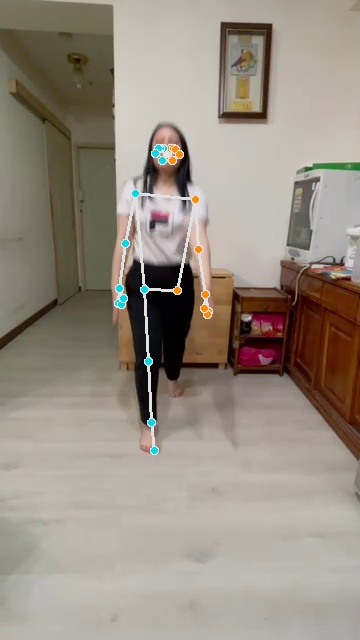

In [19]:
video = cv2.VideoCapture('C:/Users/Michael_Lee/Documents/Project_private/CGMH/EST2022/video_data/(004)jumping_same/OK.MOV')
pose = mp_pose.Pose(min_detection_confidence=0.25,min_tracking_confidence=0.5,model_complexity=2)

while True:
    success, frame = video.read()
    if not success:
        break
    if success:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = pose.process(frame)
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        mp_drawing.draw_landmarks(
                        frame,
                        results.pose_landmarks,
                        mp_pose.POSE_CONNECTIONS,
                        landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style()
                    )
        
        df, cn2 = plot_landmarks_animated(results.pose_world_landmarks,mp_pose.POSE_CONNECTIONS)
        with fig.batch_update():
            fig.data[0].x = df["z"]
            fig.data[0].y = df["x"]
            fig.data[0].z = df["y"]
            fig.data[0].hovertext = df["lm"]
            fig.data[1].x = cn2["xs"]
            fig.data[1].y = cn2["ys"]
            fig.data[1].z = cn2["zs"]
        showVideo(frame,fps=30)

video.release()

In [5]:
fig = go.FigureWidget()
fig.add_scatter3d(x=df['z'], y=df['x'], z=df['y'], hovertext=df["lm"],mode = 'markers')
fig.update_traces(marker={"color": "red"})
fig.update_layout(margin={"l": 0, "r": 0, "t": 0, "b": 0})
fig.update_layout(scene={'aspectmode':'data'})

fig.add_traces(  [
            go.Scatter3d(
                x=cn2["xs"],
                y=cn2["ys"],
                z=cn2["zs"],
                mode="lines",
                line={"color": "black", "width": 5},
                
            )
        ]
    )

FigureWidget({
    'data': [{'hovertext': array(['NOSE', 'LEFT_EYE_INNER', 'LEFT_EYE', 'LEFT_EYE_OUTER',
     …